### What is this?
EF-Tu (prokaryotic) and EF1a (eukaryotic) are proteins that bind and deliver amino-acid-charged tRNAs to the ribosome for translation.

The Uhlenbeck lab in the 2000s showed that the affinity between a charged tRNA and EF-Tu molecule is determined by a linear combination of the affinity for the amino acid and the innermost three basepairs of the T-arm. In prokaryotes, there is "thermodynamic compensation" with low-affinity T-arm basepairs associated with high-affinity amino acids and vice versa, for a narrow range of affinity between -9.5 and 10.5kcal/mol. This is conserved across different bacteria (Schrader and Uhlenbeck, 2011, doi:10.1093/nar/gkr641). This acts as 1) quality control by preventing translation with egregiously misacylated tRNAs and 2) a roadblock if that "egregious misacylation" was on purpose (biology is fun). 

"Thermodynamic compensation" has not been definitively proven for eukaryotic tRNAs and EF1a, despite several claims that it does, and significant evidence that some joint amino-acid/tRNA-body recognition is required for proper EF1a binding. This is ONLY looking at whether the amino acids and innermost three basepairs of the T-arm follow the same EXACT pattern in eukaryotic tRNAs as prokaryotic. 

### Conclusions
Prokaryotic thermodynamic compensation results in aatRNA/EF-Tu affinities significantly different from what would be achieved by random combinations of amino acid and T-arm basepairs (p=7.6e-8)

eukaryotic aatRNAs do not show a pattern *based on the values of aa and T-arm basepair affinities* (p=0.35), and is significantly different from the prokaryotic values (p=8.2e-182)

### NOT conclusions and other concerns with how I did this
This doesn't rule out thermodynamic compensation in a different way, especially since the eukaryotic tRNA-delivery system is EF1a, not EF-Tu. 

This is based on Schrader and Uhlenbeck, 2018(doi:10.1016/j.cbpa.2018.07.016), with the values compared to phenylalanine. The data does not include threonine's value, and does not have values for several tRNA basepairs. 

### Data?
The tRNA sequences are from GtRNAdb out of UCSC (Chan and Lowe, 2016 doi:10.1093/nar/gkv1309). I took all bacterial and all eukaryotic with a quality score above 56, which is "conservatively" predicted to be an active tRNA (Chan and Lowe, 2019 doi:10.1007/978-1-4939-9173-0_1). This led to ~150k eukaryotic tRNA sequences and 250k prokaryotic sequences. 

The effect of the amino acid and "Uhlenbeck pairs" is relative to properly acylated Phe-tRNAPhe, and the values come from Schrader and Uhlenbeck, 2018 (doi:10.1016/j.cbpa.2018.07.016)

### Approach?
1) Identify the T-arm and compile sequences where identification succeeded. 

I tried doing this based on conserved bases (included as commented segment, as a curiosity), but it worked better to assume the proportions of every tRNA is the same, and just use backwards indexing. In the database, eukaryotic tRNAs do not contain the 3' terminal 'CCA', while prokaryotic often do, and I clip them before indexing. I check if the T-arm is indeed there by checking if the two putatitive T-arm segments are paired in 4/5 of the positions. If I did not successfully get the T-arm, I discard the sequence. ~1.5k and 15k of eukaryotic and prokaryotic tRNAs were abandoned, respectively, mostly from differently-sized T-arm loops. 

2) Using the amino acid and the three innermost T-arm basepairs, calculate the total "ΔΔG" (the different in EF-Tu binding energy compared to Phe-tRNAPhe). 

matching the amino acid and the Uhlenbeck pairs to their values. This step also removes some weird tRNAs (initiator, suppressor), and unfortunately some tRNAs that contain Uhlenbeck pairs I do not have data for (~3k for Eukaryotes and ~4k for Prokaryotes)

3) one-way ANOVA

In [94]:
import numpy
import matplotlib.pyplot as plt
import linecache
import shutil
import itertools
from Bio import SeqIO
from Bio.Seq import Seq
import numpy as np
from scipy.stats import f_oneway

In [6]:
# #### is TNCG enough to find the t-arm? 
# f = '158278_eukaryotes.fa'
# seqiter=SeqIO.parse(open(f), 'fasta')
# ct=0
# ct0=0
# for s in seqiter:
#     desc,seq=s.id,s.seq
#     cts=seq.count(Seq("TACG"))+seq.count(Seq("TTCG"))+seq.count(Seq("TCCG"))+seq.count(Seq("TGCG"))
#     if cts != 1:
# #         print(seq.count(Seq("TTGC")))
# #         print(desc)
#         ct+=1
#     if cts==0:
#         ct0+=1
# print(ct)
# print(ct0)
# ##### No. cuts out 88256, with 25051 having no TNCG mappings at all. 

In [88]:
##### Functions

def preprocess(src, dest, output_ct=True, output_failnames=False, remove_cca=False):
    """
    takes a source file, destinatino file
    optionally whether to remove 'cca' motif and whether to print some data.
    
    uses indexing to find the tRNA, assuming 1 base overhang, 7 bases in the acceptor stem,
    five basepairs to the T-stem, and seven bases to the T-loop. 
    
    if 4/5 postions in the proposed T-stem pair (including G-U wobble), adds it to the destination file 
    
    prints (if True) how many tRNAs were removed by failure to find the T-arm,
    and what their fasta names are
    
    returns nothing.
    """
    binds = ({'G','C'},{'A','T'},{'G','T'})
    aas = {'Gly','Ala','Ser','Thr','Cys','Val','Pro','Ile','Leu','Met','His','Trp','Tyr','Phe','Lys','Arg','Gln','Asn','Asp','Glu'}
    ct = 0
    ditch = []
    
    shutil.copyfile(src,dest)
    
    seqiter = SeqIO.parse(open(src),'fasta')
    dest=open(dest,'w')
    for s in seqiter:
        desc,seq = s.id,s.seq
        if remove_cca==True and seq[-3:len(seq)]=='CCA':
            seq = seq[:-3]
        if desc.split('-')[-4] not in aas:
            pass
        else:
            bp=0
            T_top=seq[-13:-8]
            T_bottom=seq[-21:-26:-1]
            for i in range(len(T_top)):
                if {T_top[i],T_bottom[i]} not in binds:
                    bp+=1
                if bp>=2:
                    if output_ct:
                        ct+=1
                    if output_failnames:
                        ditch.append(desc)
                    break
                if i==4:
                    SeqIO.write(s,dest,'fasta')
    dest.close()
    if output_ct:
        print(str(ct)+' sequences discarded for failure to find T-arm. ')
    if output_failnames:
        print('discarded sequences: '+str(ditch))
    return

def score(src, remove_cca=False, plot=True, faildata=True):
    """
    takes a source file
    optionally, whether to remove 'cca' motif, whether to plot, 
    and whether to give the number of tRNAs that had pairings without data
    
    prints out some stats
    returns the joint scores (the addition of the amino acid and the Uhlenbeck pairs)
    """
    aa_map = {'Gly':0.7,'Ala':1.7,'Ser':-0.5,'Thr':-0.1,'Cys':-1.1,'Pro':-0.1,'Leu':0.7,'Ile':-0.2,'Val':0.4,'Met':0.4,'His':0.222,'Tyr':-0.9,'Trp':-1.1,'Phe':0,'Lys':0.4,'Arg':0.1,'Asn':-0.7,'Gln':-1.4,'Asp':1.9,'Glu':2.8}
    U_map_1 = {('C','G'):0, ('T','A'):-0.2, ('G','C'):-0.4, ('A','T'):-0.5,('G','T'):-0.9}
    U_map_2 = {('C','G'):-0.2, ('T','A'):0, ('G','C'):0, ('A','T'):0,('G','T'):1.4, ('T','G'):0.4}
    U_map_3 = {('C','G'):-0.5, ('T','A'):0, ('G','C'):-1, ('A','T'):0.1,('G','T'):-0.2, ('T','G'):0,('A','C'):-0.8}

    aa_scores=[]
    U_scores=[]
    joint=[]
    pair_fail_ct=0
    
    seqiter = SeqIO.parse(open(src),'fasta')
    for s in seqiter:
        desc,seq = s.id,s.seq
        
        if remove_cca==True and seq[-3:len(seq)]=='CCA':
            seq = seq[:-3]
            
        # get amino acid
        aa = desc.split('-')[-4]
        aa_score = aa_map[aa]
        aa_scores.append(aa_score)

        # get U-pairs
        try:
            U_score=U_map_1[(seq[-13],seq[-21])] + U_map_2[(seq[-12],seq[-22])] + U_map_3[(seq[-11],seq[-23])]
            U_scores.append(U_score)
            joint.append(aa_score+U_score)
        except:
            pair_fail_ct+=1
    
    print('max is: '+str(max(joint))+' min is: '+str(min(joint))+' average is: '+str(sum(joint)/len(joint))+' stdev is: '+str(np.std(joint)))
    if faildata:
        print ('T-arm pairs without data: '+str(pair_fail_ct))
    if plot:
        plt.hist(joint)
        plt.show()
        
    return(joint)

1472 sequences discarded for failure to find T-arm. 
max is: 3.1999999999999997 min is: -2.5999999999999996 average is: -0.32896384945088125 stdev is: 0.9460587197904704
T-arm pairs without data: 3188


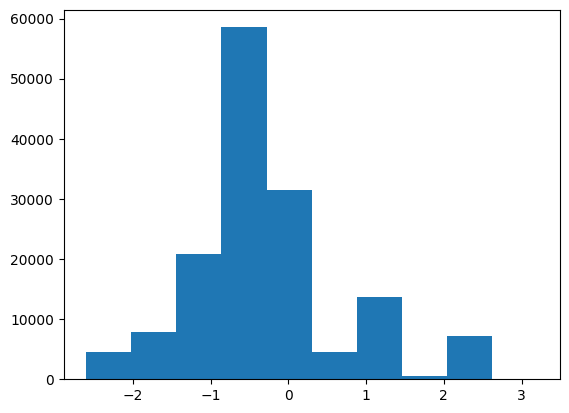

In [91]:
###### eukaryotes
f = '158278_eukaryotes.fa'
f2="eukaryotic_tRNAs.fa"
preprocess(f,f2)
eukaryote_scores = score(f2,faildata=True)

14431 sequences discarded for failure to find T-arm. 
max is: 2.8 min is: -2.5999999999999996 average is: -0.23776858624163716 stdev is: 0.9139348721095949
T-arm pairs without data: 4339


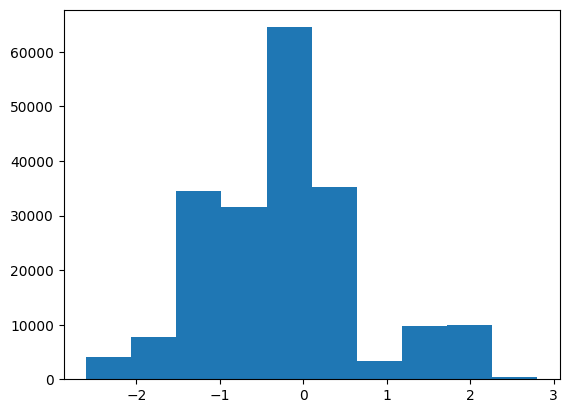

In [92]:
##### prokaryotes
f="250k_bacterial.fasta"
f2="prokaryotic_tRNAs.fa"
preprocess(f,f2,remove_cca=True)
prokaryote_scores = score(f2,remove_cca=True, faildata=True)

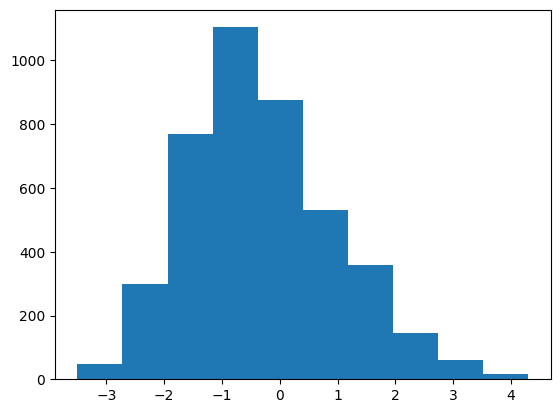

max is: 4.299999999999999 min is: -3.5 average is: -0.3150904761904758 stdev is: 1.2676717696720956


In [93]:
##### overall space to look at and its distribution

aa_map = {'Gly':0.7,'Ala':1.7,'Ser':-0.5,'Thr':-0.1,'Cys':-1.1,'Pro':-0.1,'Leu':0.7,'Ile':-0.2,'Val':0.4,'Met':0.4,'His':0.222,'Tyr':-0.9,'Trp':-1.1,'Phe':0,'Lys':0.4,'Arg':0.1,'Asn':-0.7,'Gln':-1.4,'Asp':1.9,'Glu':2.8}
U_map_1 = {('C','G'):0, ('U','A'):-0.2, ('G','C'):-0.4, ('A','U'):-0.5,('G','U'):-0.9}
U_map_2 = {('C','G'):-0.2, ('U','A'):0, ('G','C'):0, ('A','U'):0,('G','U'):1.4, ('U','G'):0.4}
U_map_3 = {('C','G'):-0.5, ('U','A'):0, ('G','C'):-1, ('A','U'):0.1,('G','U'):-0.2, ('U','G'):0,('A','C'):-0.8}

aa_list=aa_map.values()
u1_list=U_map_1.values()
u2_list=U_map_2.values()
u3_list=U_map_3.values()

all_combos=list(itertools.product(*[aa_list,u1_list,u2_list,u3_list]))

ground = [sum(tup) for tup in all_combos]

plt.hist(ground)
plt.show()

print('max is: '+str(max(ground))+' min is: '+str(min(ground))+' average is: '+str(sum(ground)/len(ground))+' stdev is: '+str(np.std(ground)))


In [97]:
##### statistically significant difference in averages?
f_stat, p_val = f_oneway(eukaryote_scores, prokaryote_scores, ground)
print('f-statistic: '+str(f_stat))
print('pval: '+str(p_val)) #p-val is 5.8e-180

ep_f_stat, ep_p_val=f_oneway(eukaryote_scores, prokaryote_scores)
print('f-statistic (eu/pro): '+str(ep_f_stat))
print('pval (eu/pro): '+str(ep_p_val)) #8.15e-182

eg_f_stat, eg_p_val=f_oneway(eukaryote_scores, ground)
print('f-statistic (eu/ground): '+str(eg_f_stat))
print('pval (eu/ground): '+str(eg_p_val)) #0.353

pg_f_stat, pg_p_val=f_oneway(prokaryote_scores, ground)
print('f-statistic (pro/ground): '+str(pg_f_stat))
print('pval (pro/ground): '+str(pg_p_val)) #7.62e-8

f-statistic: 413.194008263444
pval: 5.7670954614473135e-180
f-statistic (eu/pro): 827.7506859138061
pval (eu/pro): 8.151414327888956e-182
f-statistic (eu/ground): 0.859754972562684
pval (eu/ground): 0.35380872756584636
f-statistic (pro/ground): 28.900192130948305
pval (pro/ground): 7.62882372073714e-08
